In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/the_datas/data/"

SEED = 42 # 시드값

# 데이터 블러오기
train_tr = pd.read_csv(f"{DATA_PATH}store_train_transactions.csv") # 학습용 구매기록 데이터
train_target = pd.read_csv(f"{DATA_PATH}store_train.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"{DATA_PATH}store_test_transactions.csv") # 테스트용 구매기록 데이터
submit = pd.read_csv(f"{DATA_PATH}store_submission.csv") # 제출 양식 데이터

train_tr.shape , train_target.shape , test_tr.shape , submit.shape



Mounted at /content/drive


((523105, 7), (14940, 2), (441196, 7), (12225, 2))

In [2]:
# 특성추출

##ONLY ID
train_ft = train_target[["ID"]]
test_ft = submit[["ID"]]

## 구매일시
train_tr["구매일시"] = pd.to_datetime(train_tr["구매일시"])
test_tr["구매일시"] = pd.to_datetime(test_tr["구매일시"])

agg_list = [
        # 컬럼명, 집계 방식
        ('내점일수','nunique'),
        ('구매주기', lambda x: int( (x.max() - x.min()).days / x.dt.date.nunique()) ),
        ('주말방문비율', lambda x: np.mean(x.dt.weekday>4)),
        ('봄_구매비율', lambda x: np.mean(x.dt.month.isin([3,4,5]))),
        ('여름_구매비율', lambda x: np.mean(x.dt.month.isin([6,7,8]))),
        ('가을_구매비율', lambda x: np.mean(x.dt.month.isin([9,10,11]))),
        ('겨울_구매비율', lambda x: np.mean(x.dt.month.isin([1,2,12]))),
        ('주구매요일', lambda x: x.dt.weekday.mode()[0]),
        ('일별평균구매건수', lambda x:  x.count() / x.dt.date.nunique() ),
        ('거래개월수', lambda x: x.dt.date.astype(str).str[:-3].nunique() ),
    ]

tmp = train_tr.groupby('ID')["구매일시"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left',on="ID")
train_ft.head()

tmp = test_tr.groupby('ID')["구매일시"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left',on="ID")
test_ft.head()

##지점
agg_list = [
          ("방문지점수","nunique"),
          ('주구매지점', lambda x: x.mode()[0]),
    ]

tmp = train_tr.groupby('ID')["지점코드"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left',on="ID")
train_ft.head()

tmp = test_tr.groupby('ID')["지점코드"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left',on="ID")
test_ft.head()

##브랜드코드
agg_list = [
             ('브랜드코드_nunique', 'nunique'),
             ]

tmp = train_tr.groupby('ID')["브랜드코드"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left',on="ID")
train_ft.head()

tmp = test_tr.groupby('ID')["브랜드코드"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left',on="ID")
test_ft.head()

##중분류
agg_list = [
            ('중분류_nunique', 'nunique'),
            ('주구매_중분류', lambda x: x.mode()[0]),
            ]
tmp = train_tr.groupby('ID')["중분류"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
train_ft.head()

tmp = test_tr.groupby('ID')["중분류"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')
test_ft.head()

##대분류
agg_list = [
            ('대분류_nunique', 'nunique'),
            ('주구매_대분류', lambda x: x.mode()[0]),
            ]

tmp = train_tr.groupby('ID')["대분류"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
train_ft.head()

tmp = test_tr.groupby('ID')["대분류"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')
test_ft.head()

##구매가격
agg_list = [
        ('총구매액','sum'),
        ('구매건수', 'count'),
        ('평균구매액', "mean"),
        ('최대구매액', 'max'),
        ('최소구매액',lambda x: x[x > 0].min() ) ,
        ('환불금액',lambda x: x[x < 0].sum() ) ,
        ('환불건수', lambda x: ( x < 0 ).sum() ),
        ('구매금액표준편차',lambda x: x[x>0].std() ),
    ]

tmp = train_tr.groupby('ID')["구매가격"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
train_ft.head()

tmp = test_tr.groupby('ID')["구매가격"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')
test_ft.head()

## pivot table - 중분류 + 구매가격
train_tmp = pd.pivot_table(train_tr,index="ID",columns="중분류",values="구매가격",aggfunc="count",fill_value=0).add_prefix("pivot_cnt_").reset_index()
train_ft = train_ft.merge(train_tmp,how="left",on="ID")
train_ft.head()

test_tmp = pd.pivot_table(test_tr,index="ID",columns="중분류",values="구매가격",aggfunc="count",fill_value=0).add_prefix("pivot_cnt_").reset_index()
test_tmp.head()

for col in train_tmp.columns:
    if col not in test_tmp.columns:
        test_tmp[col] = 0

test_tmp = test_tmp[train_tmp.columns]
test_ft = test_ft.merge(test_tmp,how="left",on="ID")
test_ft.head()

##확인
train_ft.shape, test_ft.shape


# train_ft.to_csv(f"{DATA_PATH}train_common.csv",index=False)
# test_ft.to_csv(f"{DATA_PATH}test_common.csv",index=False)

((14940, 329), (12225, 329))

In [5]:
cols = [ col for col in train_ft.columns if col.startswith("pivot_cnt_") ]
train_ft["중분류별_구매횟수_std"] = train_ft[cols].std(axis=1)
train_ft["중분류별_구매횟수_skew"] = train_ft[cols].skew(axis=1)
train_ft["중분류별_구매횟수_kurt"] = train_ft[cols].kurt(axis=1)

test_ft["중분류별_구매횟수_std"] = test_ft[cols].std(axis=1)
test_ft["중분류별_구매횟수_skew"] = test_ft[cols].skew(axis=1)
test_ft["중분류별_구매횟수_kurt"] = test_ft[cols].kurt(axis=1)

In [3]:
# train_ft = pd.read_csv(f"{DATA_PATH}train_common.csv") # 학습 데이터(피처)
# test_ft = pd.read_csv(f"{DATA_PATH}test_common.csv") # 테스트 데이터(피처)

# train_ft.shape , test_ft.shape

In [4]:
#ID 변수 제외
train_ft = train_ft.iloc[:,1:]
test_ft = test_ft.iloc[:,1:]
train_ft.shape, test_ft.shape

((14940, 328), (12225, 328))

In [6]:
# 결측치 처리
mask = train_ft.isnull().sum() > 0
train_ft.isnull().sum()[mask]

mask = test_ft.isnull().sum() > 0
test_ft.isnull().sum()[mask]

train_ft["구매금액표준편차"] = train_ft["구매금액표준편차"].fillna(0)
test_ft["구매금액표준편차"] = test_ft["구매금액표준편차"].fillna(0)

train_ft.isnull().sum().sum(), test_ft.isnull().sum().sum()

(0, 0)

In [7]:
# 범주형 변수 인코딩
cols = train_ft.select_dtypes("object").columns.tolist()
train_ft[cols].nunique()

%pip install category_encoders

import category_encoders as ce

enc = ce.one_hot.OneHotEncoder()
tmp = enc.fit_transform(train_ft[["주구매지점","주구매_대분류"]])
train_ft = pd.concat([train_ft,tmp],axis =1)

tmp = enc.transform(test_ft[["주구매지점","주구매_대분류"]])
test_ft = pd.concat([test_ft,tmp],axis =1)

enc = ce.count.CountEncoder()
train_ft["주구매_중분류_cnt"] = enc.fit_transform(train_ft[["주구매_중분류"]])
test_ft["주구매_중분류_cnt"] = enc.transform(test_ft[["주구매_중분류"]])

train_ft.shape, test_ft.shape

##범주형 피처 삭제
train_ft = train_ft.drop(columns=cols)
test_ft = test_ft.drop(columns=cols)
train_ft.select_dtypes("object").columns , test_ft.select_dtypes("object").columns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.0 MB/s eta 0:00:00


(Index([], dtype='object'), Index([], dtype='object'))

In [8]:
# 스케일링
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# train_ft[train_ft.columns] = scaler.fit_transform(train_ft)
# test_ft[test_ft.columns] = scaler.transform(test_ft)
# train_ft.head()

# 정답 데이터
target = train_target["target"]
target

train_ft.shape, test_ft.shape, target.shape

((14940, 361), (12225, 361), (14940,))

In [11]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits = 5, shuffle = True, random_state = SEED)

model = LGBMClassifier(random_state = SEED)
scores = cross_val_score(model, train_ft, target, scoring = 'f1_macro', cv = cv, n_jobs = -1)
scores.mean()

0.6936788592990742

In [12]:
pip install shap

In [13]:
model.fit(train_ft, target)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5874, number of negative: 9066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7806
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995


LGBMClassifier(random_state=42)

In [15]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 4s (2,672 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123623 files and dire

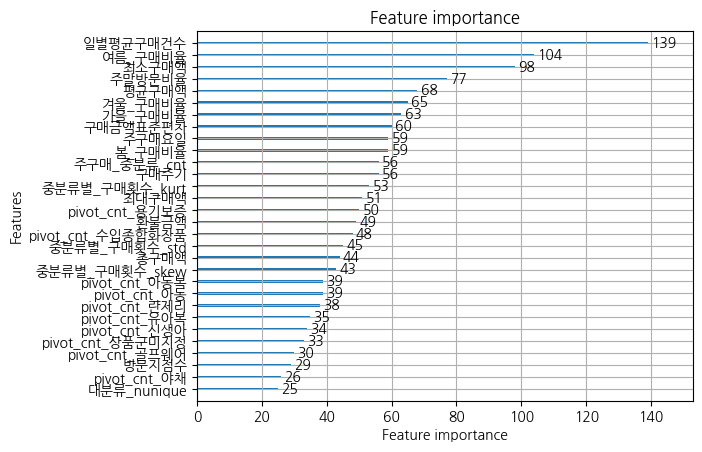

In [23]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
plot_importance(model, max_num_features=30)
plt.show()

In [17]:
import shap

In [18]:
explainer = shap.TreeExplainer(model)

In [19]:
shap_values = explainer.shap_values(test_ft)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


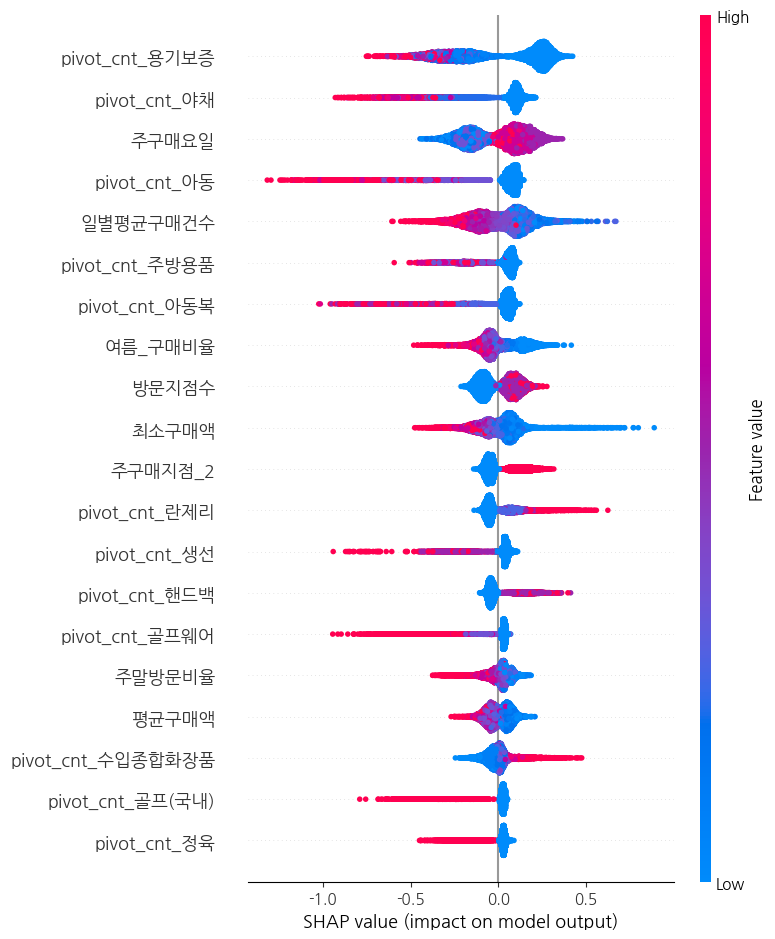

In [20]:
shap.summary_plot(shap_values, test_ft)

In [22]:
for col in test_ft.columns:
    shap.dependence_plot(col, shap_values, test_ft, interaction_index = "auto")
    print()

Output hidden; open in https://colab.research.google.com to view.